# Mining Process - Exploratory Data Analysis (EDA)

## What is EDA and Why Do We Do It?

EDA is NOT just making plots. It's about **making decisions** for modeling:
- Which features to keep or drop?
- What model type is appropriate?
- What data quality issues need fixing?
- What questions should we ask the business?

**Every plot should lead to an insight. Every insight should lead to an action.**

---

## Our Goal: Digital Twin

Build an ML model that predicts output quality from process settings.

**Can we predict multiple outputs?** Yes - this is called multi-output regression. We could predict:
- % Silica Concentrate (impurity)
- % Iron Concentrate (product quality)
- Energy consumption (if we had that data)

This is useful when you need to optimize trade-offs (e.g., quality vs energy cost).

---
## The Process: Froth Flotation

```
CRUSHED ORE (iron + silica mixed)
         ↓
   Add water → PULP (slurry)
         ↓
   Add chemicals (starch, amina)
         ↓
   Blow air through FLOTATION COLUMNS
         ↓
   Iron sticks to bubbles → floats up → CONCENTRATE (good stuff)
   Silica sinks → TAILINGS (waste)
```

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')

df = pd.read_csv('../data/processed/mining_hourly.csv', parse_dates=['date'])
df = df.set_index('date')

print(f'Dataset: {df.shape[0]} hours x {df.shape[1]} columns')
print(f'Time range: {df.index.min()} to {df.index.max()}')

Dataset: 4097 hours x 23 columns
Time range: 2017-03-10 01:00:00 to 2017-09-09 23:00:00


---
## Step 1: Organize Columns by Type

**Critical first step:** Understand what each column IS before doing anything else.

| Type | Can we control it? | Use in model? |
|------|-------------------|---------------|
| **Output** | No - it's the result | Predict this |
| **Uncontrollable Input** | No - nature decides | Use as input (can't optimize, but affects output) |
| **Controllable Input** | Yes - operators adjust | Use as input (CAN optimize) |

In [17]:
# OUTPUTS - Lab measurements of final product (what we PREDICT)
outputs = ['% Iron Concentrate', '% Silica Concentrate']

# UNCONTROLLABLE INPUTS - Ore quality from mine (CAN'T control, but affects output)
ore_quality = ['% Iron Feed', '% Silica Feed']

# CONTROLLABLE INPUTS - Process settings (CAN optimize)
reagents = ['Starch Flow', 'Amina Flow']
pulp = ['Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density']
air_flows = [f'Flotation Column 0{i} Air Flow' for i in range(1, 8)]
levels = [f'Flotation Column 0{i} Level' for i in range(1, 8)]

controllable = reagents + pulp + air_flows + levels
all_inputs = ore_quality + controllable

print('COLUMN CLASSIFICATION')
print('='*60)
print(f'OUTPUTS (predict these):           {len(outputs)} - {outputs}')
print(f'UNCONTROLLABLE INPUTS (ore):       {len(ore_quality)} - {ore_quality}')
print(f'CONTROLLABLE INPUTS (optimize):    {len(controllable)}')
print(f'  - Reagents: {reagents}')
print(f'  - Pulp: {pulp}')
print(f'  - Air Flows: 7 columns')
print(f'  - Levels: 7 columns')
print(f'\nTOTAL INPUTS FOR MODEL: {len(all_inputs)}')

COLUMN CLASSIFICATION
OUTPUTS (predict these):           2 - ['% Iron Concentrate', '% Silica Concentrate']
UNCONTROLLABLE INPUTS (ore):       2 - ['% Iron Feed', '% Silica Feed']
CONTROLLABLE INPUTS (optimize):    19
  - Reagents: ['Starch Flow', 'Amina Flow']
  - Pulp: ['Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density']
  - Air Flows: 7 columns
  - Levels: 7 columns

TOTAL INPUTS FOR MODEL: 21


---
## Step 2: Summary Statistics by Category

Look at each group separately to understand operating ranges.

In [18]:
def show_stats(cols, title):
    print(f'\n{title}')
    print('='*70)
    print(df[cols].describe().T[['mean', 'std', 'min', 'max']].round(2))

show_stats(outputs, 'OUTPUTS (what we predict)')
show_stats(ore_quality, 'ORE QUALITY (uncontrollable - from mine)')
show_stats(reagents, 'REAGENTS (controllable - chemical additions)')
show_stats(pulp, 'PULP PROPERTIES (controllable)')
show_stats(air_flows, 'AIR FLOWS (controllable)')
show_stats(levels, 'LEVELS (controllable)')


OUTPUTS (what we predict)
                       mean   std    min    max
% Iron Concentrate    65.05  1.12  62.05  68.01
% Silica Concentrate   2.33  1.12   0.60   5.53

ORE QUALITY (uncontrollable - from mine)
                mean   std    min    max
% Iron Feed    56.29  5.16  42.74  65.78
% Silica Feed  14.65  6.81   1.31  33.40

REAGENTS (controllable - chemical additions)
                mean     std     min      max
Starch Flow  2869.14  950.48   54.60  6270.16
Amina Flow    488.15   83.69  242.93   736.98

PULP PROPERTIES (controllable)
                    mean   std     min     max
Ore Pulp Flow     397.58  8.37  376.84  418.07
Ore Pulp pH         9.77  0.38    8.75   10.81
Ore Pulp Density    1.68  0.06    1.52    1.83

AIR FLOWS (controllable)
                                mean    std     min     max
Flotation Column 01 Air Flow  280.15  29.41  175.89  312.30
Flotation Column 02 Air Flow  277.16  29.42  178.19  309.89
Flotation Column 03 Air Flow  281.08  28.37  177.20  3

### Observations:

1. **Air Flow 04, 05** have very low std (~2-3) - nearly constant. Probably fixed setpoints.
2. **Ore quality varies a lot** - Iron Feed ranges 43-66%. This is our main uncontrollable variability.
3. **Starch Flow** has huge range (55-6270) - major control lever.

---
## Step 3: Output Distributions

**Business question:** What does good vs bad performance look like?

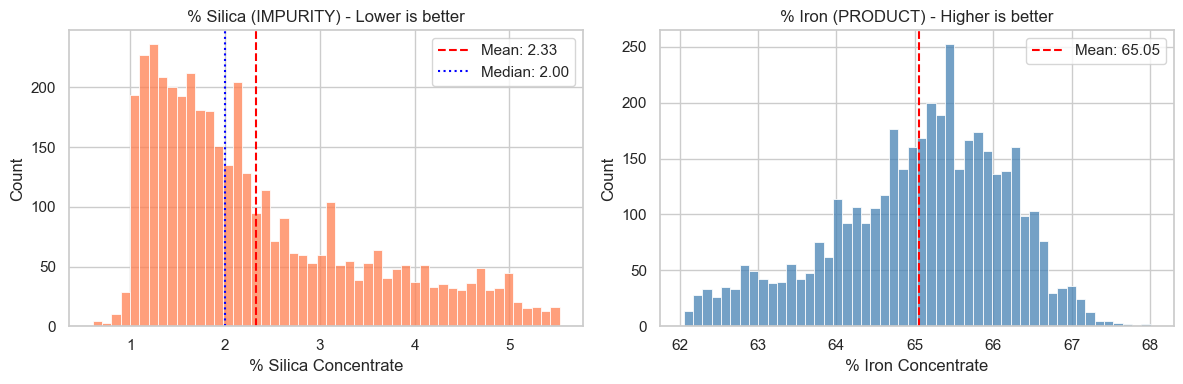

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df['% Silica Concentrate'], bins=50, ax=axes[0], color='coral')
axes[0].axvline(df['% Silica Concentrate'].mean(), color='red', linestyle='--', label=f"Mean: {df['% Silica Concentrate'].mean():.2f}")
axes[0].axvline(df['% Silica Concentrate'].median(), color='blue', linestyle=':', label=f"Median: {df['% Silica Concentrate'].median():.2f}")
axes[0].set_title('% Silica (IMPURITY) - Lower is better')
axes[0].legend()

sns.histplot(df['% Iron Concentrate'], bins=50, ax=axes[1], color='steelblue')
axes[1].axvline(df['% Iron Concentrate'].mean(), color='red', linestyle='--', label=f"Mean: {df['% Iron Concentrate'].mean():.2f}")
axes[1].set_title('% Iron (PRODUCT) - Higher is better')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/processed/eda_01_output_distributions.png', dpi=150)

### Business Insight:

- Silica is **right-skewed**: Most hours are good (low silica), but there's a tail of bad hours
- Mean > Median confirms skew
- **We have a "bad batch" problem**, not a "consistently mediocre" problem
- Digital twin should help predict/prevent the bad hours

---
## Step 4: Input Distributions

See how each input variable is distributed.

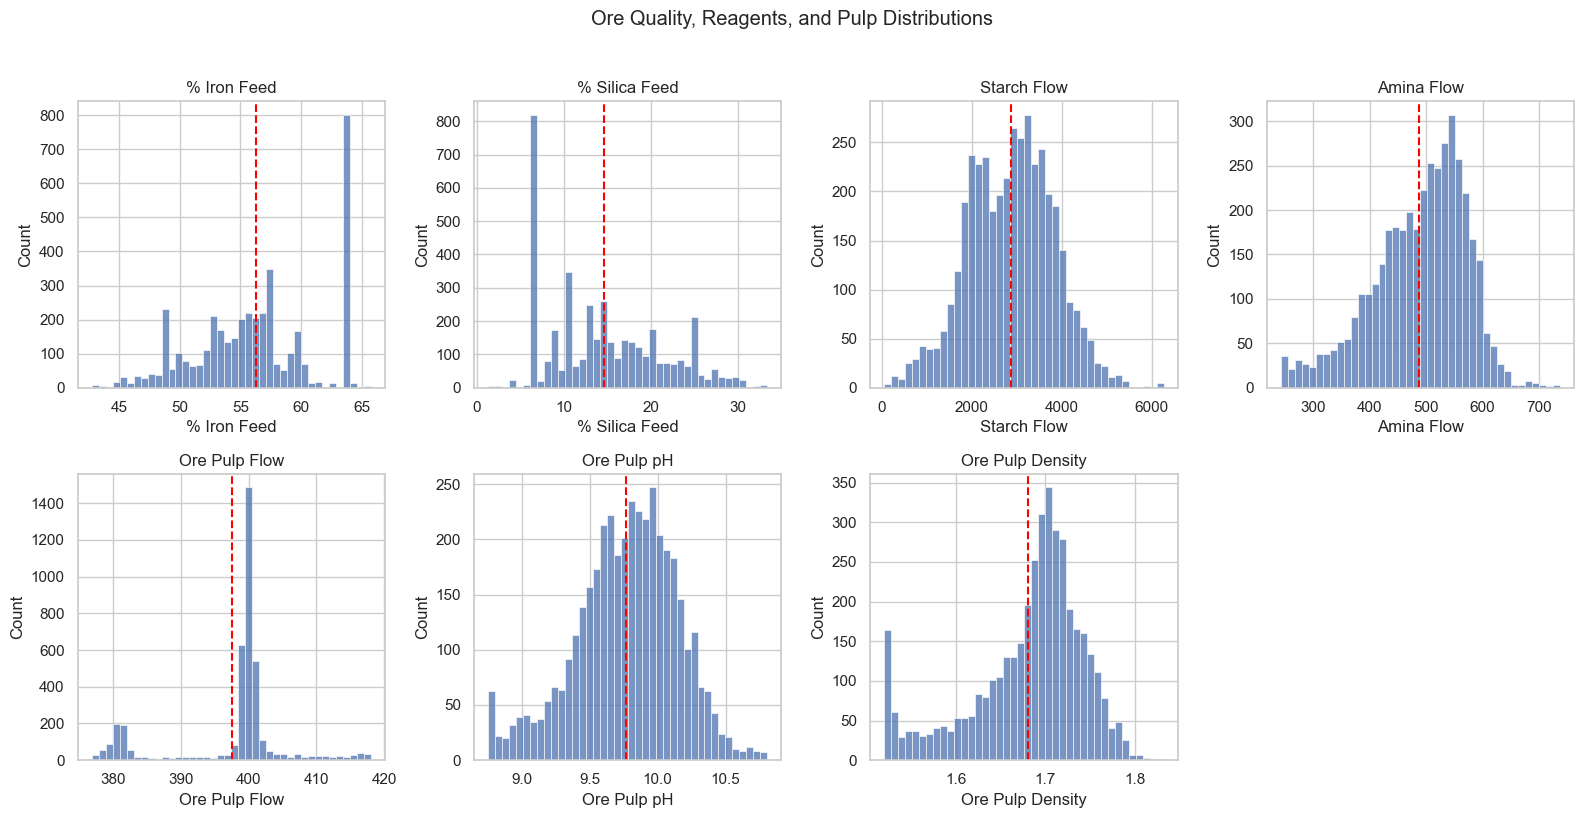

In [20]:
# Ore quality + Reagents + Pulp
plot_vars = ore_quality + reagents + pulp
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(plot_vars):
    sns.histplot(df[col], bins=40, ax=axes[i])
    axes[i].axvline(df[col].mean(), color='red', linestyle='--')
    axes[i].set_title(col)

axes[7].set_visible(False)
plt.suptitle('Ore Quality, Reagents, and Pulp Distributions', y=1.02)
plt.tight_layout()
plt.savefig('../data/processed/eda_02_input_distributions.png', dpi=150)

---
## Step 5: Correlations with Output (ALL inputs)

**Business question:** Which knobs actually affect quality?

We show ALL inputs, not just top ones.


Correlation values:
  -0.221  Flotation Column 01 Air Flow
  -0.220  Flotation Column 03 Air Flow
  -0.191  Flotation Column 05 Level
  -0.179  Flotation Column 04 Level
  -0.172  Flotation Column 02 Air Flow
  -0.166  Flotation Column 07 Level
  -0.151  Ore Pulp pH
  -0.122  Flotation Column 06 Level
  -0.085  Starch Flow
  -0.077  % Iron Feed
  -0.076  Flotation Column 07 Air Flow
  -0.051  Flotation Column 06 Air Flow
  -0.010  Flotation Column 05 Air Flow
  -0.005  Flotation Column 04 Air Flow
  +0.010  Ore Pulp Flow
  +0.016  Flotation Column 03 Level
  +0.018  Flotation Column 01 Level
  +0.034  Flotation Column 02 Level
  +0.051  Ore Pulp Density
  +0.073  % Silica Feed
  +0.171  Amina Flow


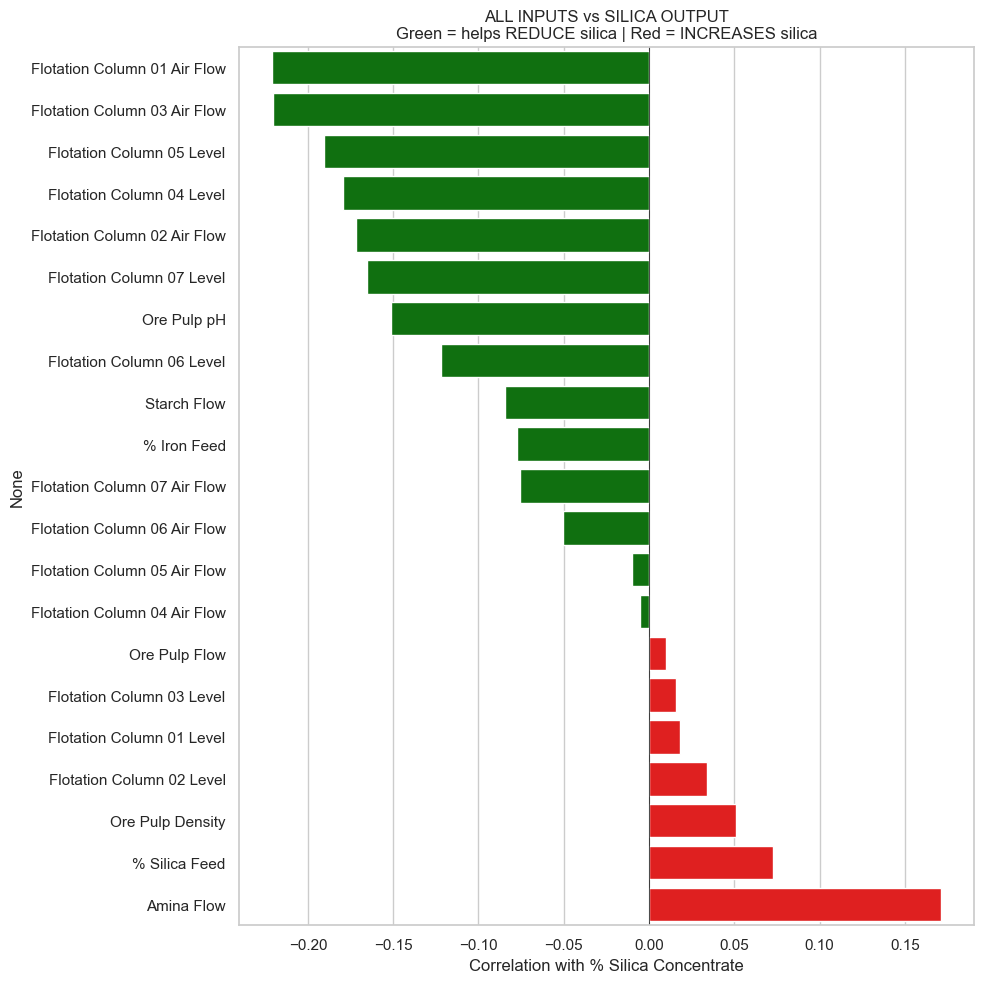

In [21]:
target = '% Silica Concentrate'
correlations = df[all_inputs].corrwith(df[target]).sort_values()

fig, ax = plt.subplots(figsize=(10, 10))
colors = ['green' if c < 0 else 'red' for c in correlations]
sns.barplot(x=correlations.values, y=correlations.index, hue=correlations.index, palette=colors, legend=False, ax=ax)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('Correlation with % Silica Concentrate')
ax.set_title('ALL INPUTS vs SILICA OUTPUT\nGreen = helps REDUCE silica | Red = INCREASES silica')

plt.tight_layout()
plt.savefig('../data/processed/eda_03_all_correlations.png', dpi=150)

# Print values
print('\nCorrelation values:')
for col, corr in correlations.items():
    print(f'  {corr:+.3f}  {col}')

### Business Insight:

| Input | Correlation | Meaning |
|-------|-------------|--------|
| Air Flow 01, 03 | -0.22 | More air → less silica (strongest effect) |
| Levels 04, 05 | -0.18 | Higher level → less silica |
| Ore Pulp pH | -0.15 | Higher pH → less silica |
| Amina Flow | +0.17 | More amina → MORE silica (counterintuitive?) |
| Starch Flow | -0.09 | More starch → less silica (weak) |
| % Iron Feed | -0.08 | Better ore → less silica (makes sense) |

**Why are correlations weak?**
- No single control dominates
- Quality depends on **combinations** of settings
- Relationships are likely **non-linear**
- **This is why we need ML**, not simple rules

---
## Step 6: Scatter Plots - ALL Input Categories vs Output

Correlation is a number. Scatter plots show the actual shape.

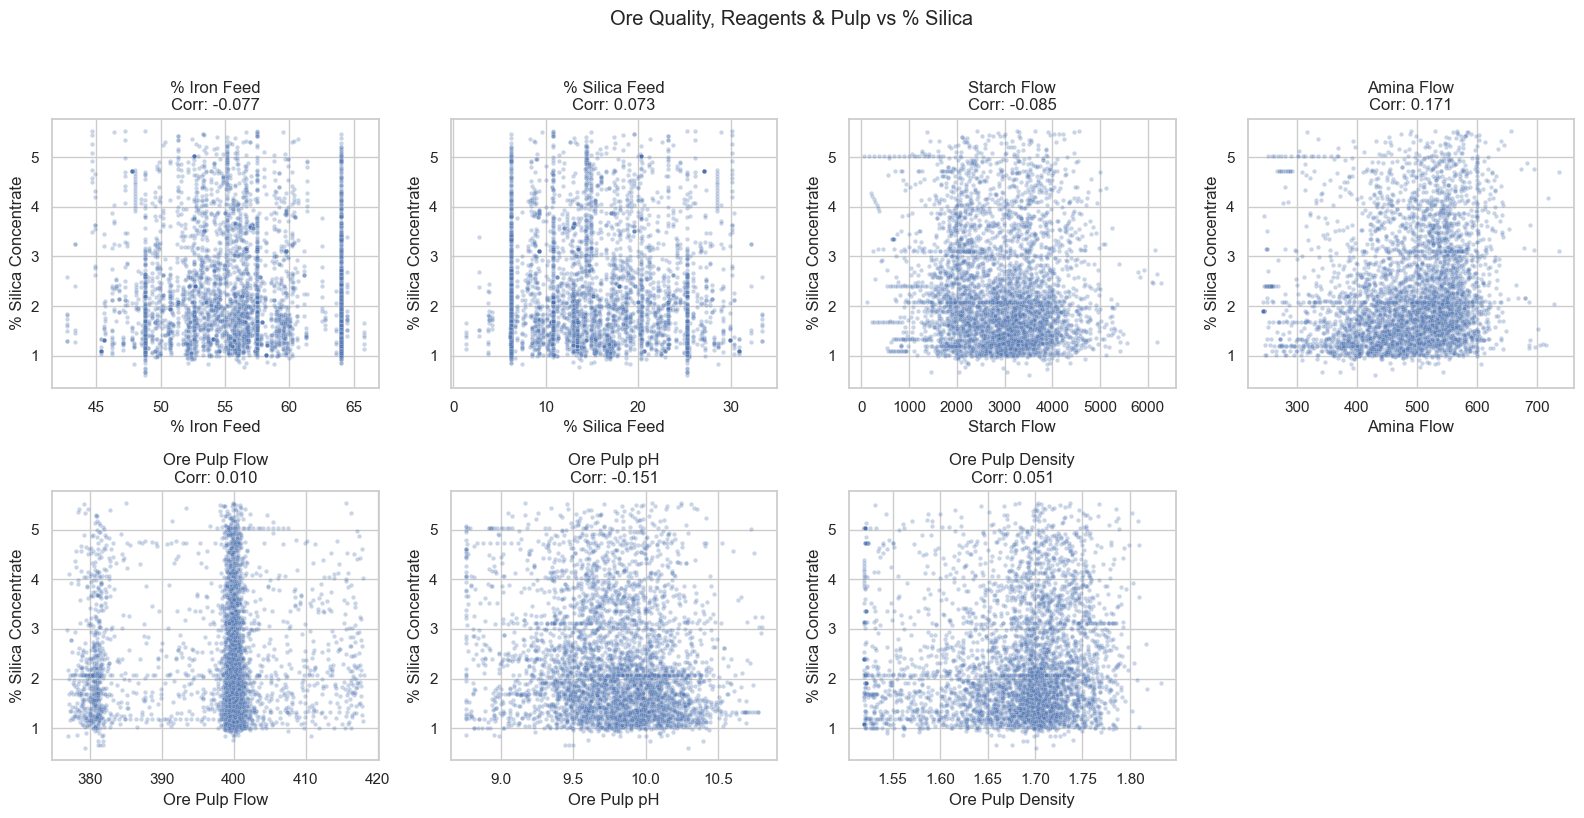

In [22]:
# Ore quality + Reagents + Pulp vs Silica
plot_vars = ore_quality + reagents + pulp
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(plot_vars):
    sns.scatterplot(data=df, x=col, y=target, ax=axes[i], alpha=0.3, s=10)
    corr = df[col].corr(df[target])
    axes[i].set_title(f'{col}\nCorr: {corr:.3f}')

axes[7].set_visible(False)
plt.suptitle('Ore Quality, Reagents & Pulp vs % Silica', y=1.02)
plt.tight_layout()
plt.savefig('../data/processed/eda_04_scatter_process.png', dpi=150)

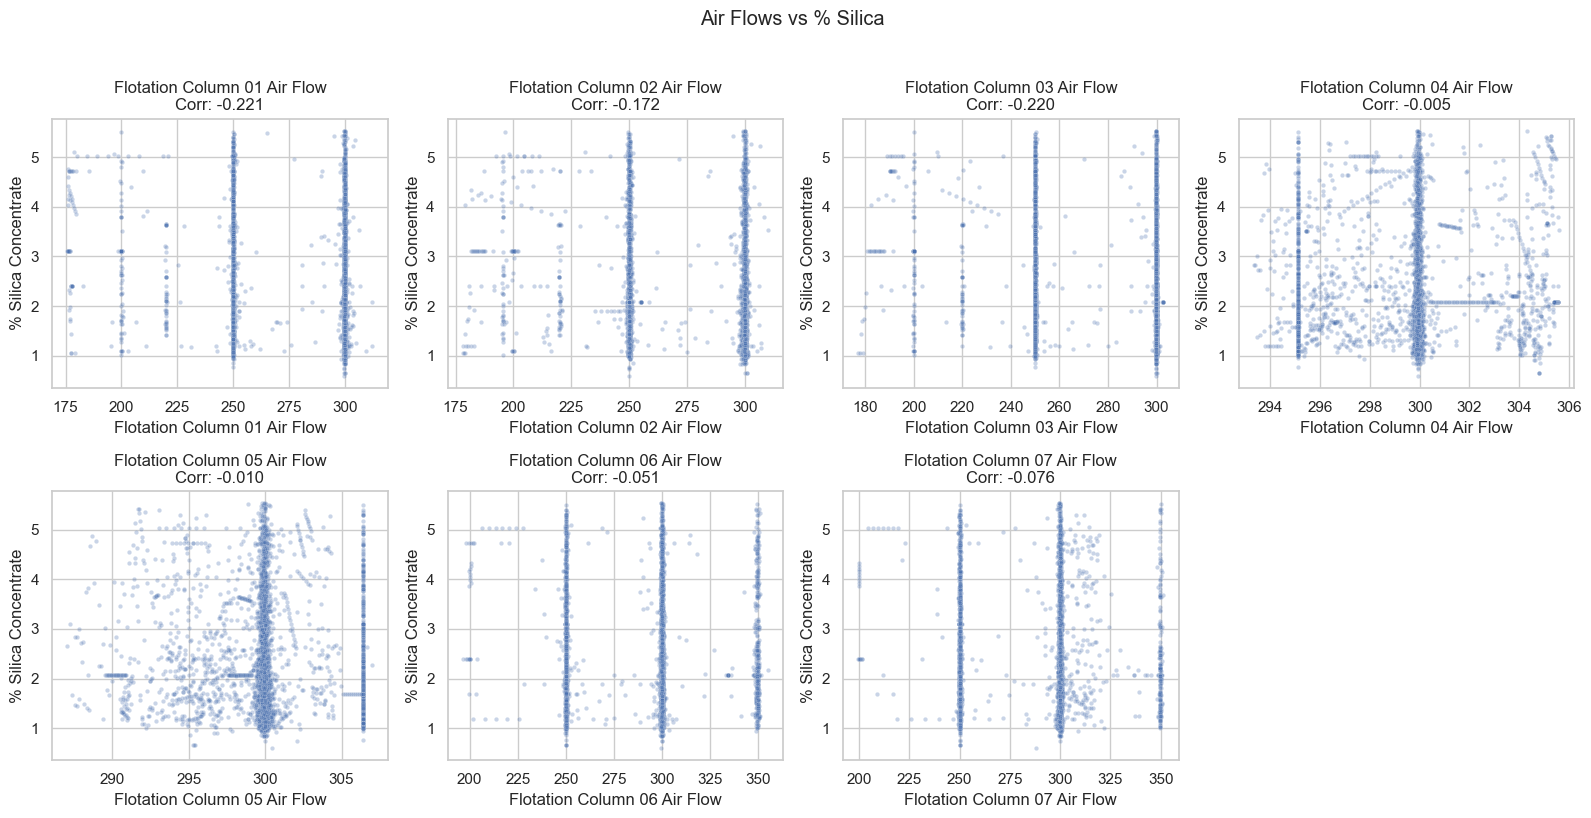

In [23]:
# Air Flows vs Silica
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(air_flows):
    sns.scatterplot(data=df, x=col, y=target, ax=axes[i], alpha=0.3, s=10)
    corr = df[col].corr(df[target])
    axes[i].set_title(f'{col}\nCorr: {corr:.3f}')

axes[7].set_visible(False)
plt.suptitle('Air Flows vs % Silica', y=1.02)
plt.tight_layout()
plt.savefig('../data/processed/eda_05_scatter_airflows.png', dpi=150)

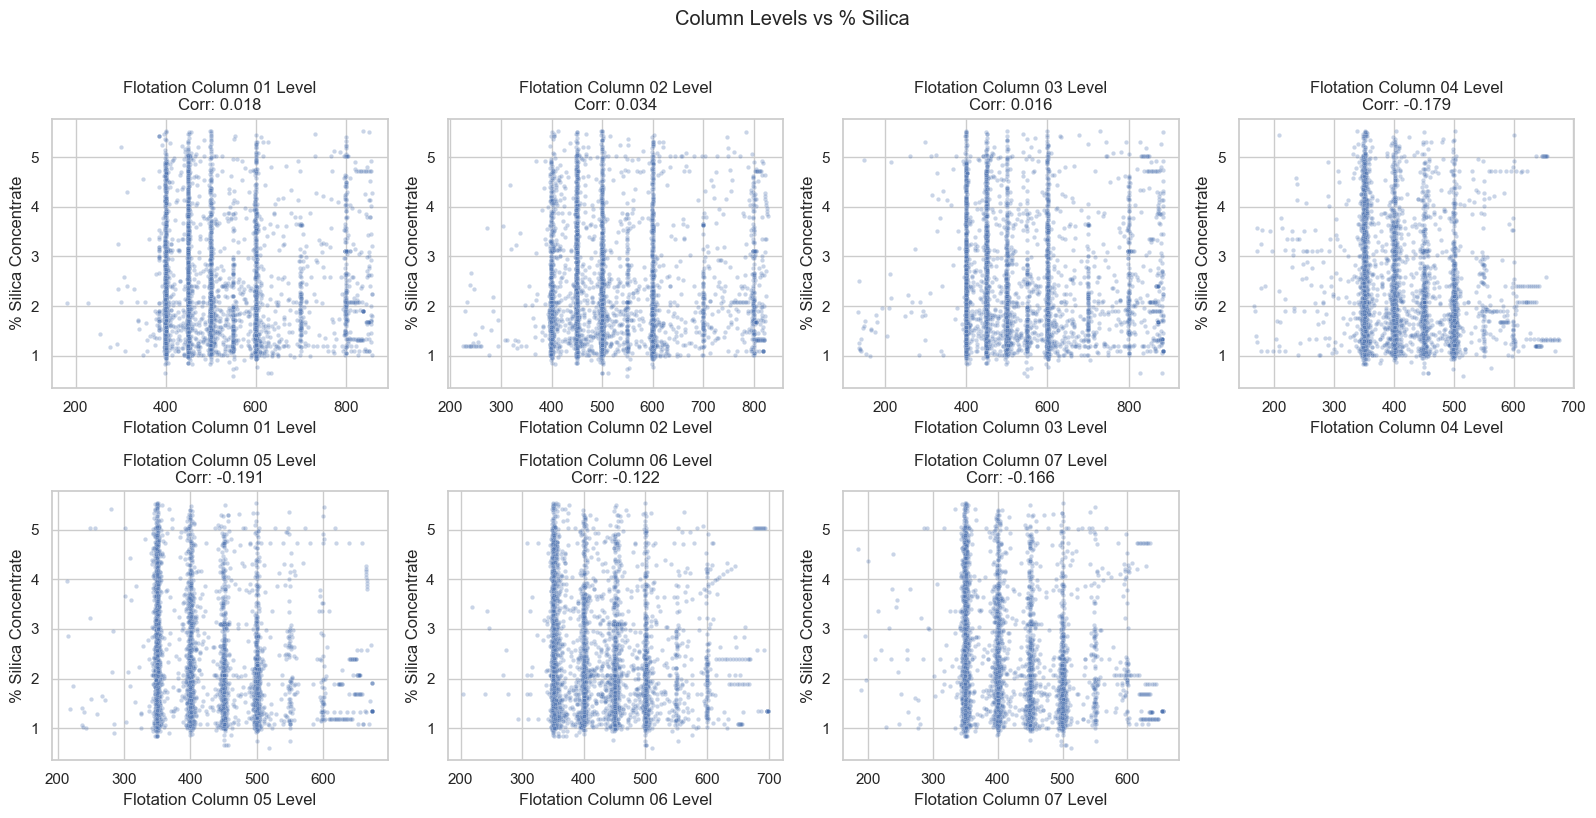

In [24]:
# Levels vs Silica
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(levels):
    sns.scatterplot(data=df, x=col, y=target, ax=axes[i], alpha=0.3, s=10)
    corr = df[col].corr(df[target])
    axes[i].set_title(f'{col}\nCorr: {corr:.3f}')

axes[7].set_visible(False)
plt.suptitle('Column Levels vs % Silica', y=1.02)
plt.tight_layout()
plt.savefig('../data/processed/eda_06_scatter_levels.png', dpi=150)

### Business Insight:

All scatter plots show **clouds, not lines**:
- Same input value can give different outputs
- No simple "if X then Y" rules work
- ML is needed to capture complex interactions

---
## Step 7: Input-Input Correlations (Redundancy)

**Business question:** Are some controls actually linked? Should we group them?

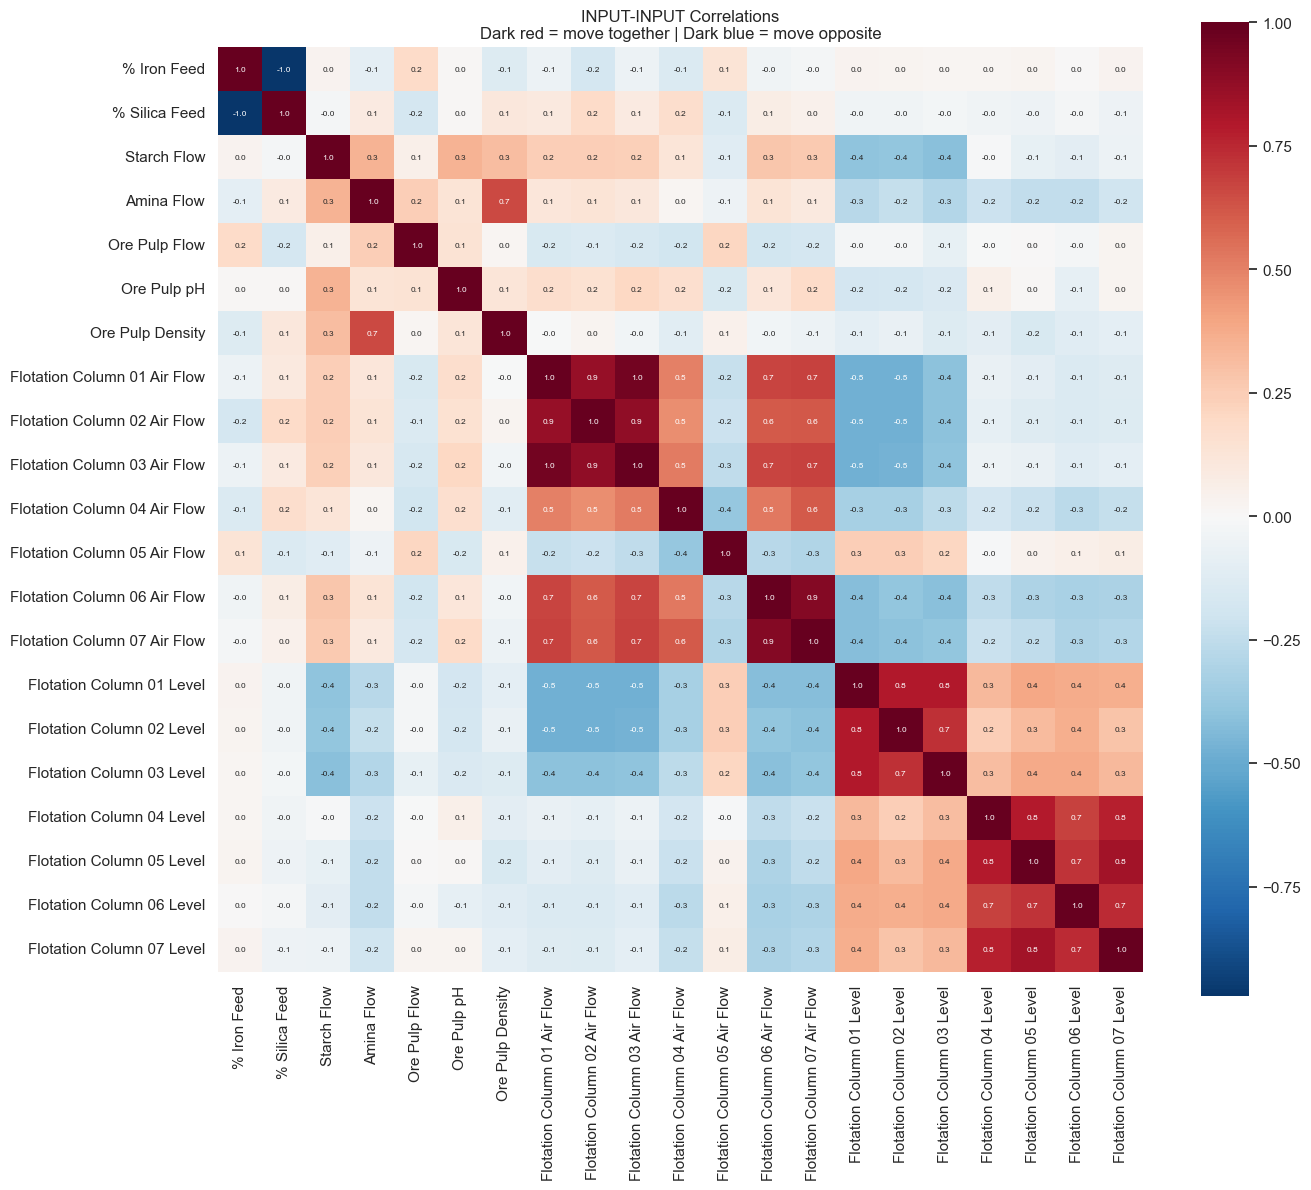

In [25]:
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(df[all_inputs].corr(), annot=True, fmt='.1f', cmap='RdBu_r', 
            center=0, square=True, annot_kws={'size': 6}, ax=ax)
ax.set_title('INPUT-INPUT Correlations\nDark red = move together | Dark blue = move opposite')
plt.tight_layout()
plt.savefig('../data/processed/eda_07_input_correlations.png', dpi=150)

In [26]:
# Find highly correlated pairs
print('HIGHLY CORRELATED INPUT PAIRS (|corr| > 0.8)')
print('='*70)
print('These inputs move together - ask operations why')
print()

corr_matrix = df[all_inputs].corr()
for i in range(len(all_inputs)):
    for j in range(i+1, len(all_inputs)):
        c = corr_matrix.iloc[i, j]
        if abs(c) > 0.8:
            print(f'  {c:+.2f}  {all_inputs[i]} <-> {all_inputs[j]}')

HIGHLY CORRELATED INPUT PAIRS (|corr| > 0.8)
These inputs move together - ask operations why

  -0.97  % Iron Feed <-> % Silica Feed
  +0.87  Flotation Column 01 Air Flow <-> Flotation Column 02 Air Flow
  +0.96  Flotation Column 01 Air Flow <-> Flotation Column 03 Air Flow
  +0.88  Flotation Column 02 Air Flow <-> Flotation Column 03 Air Flow
  +0.91  Flotation Column 06 Air Flow <-> Flotation Column 07 Air Flow
  +0.84  Flotation Column 05 Level <-> Flotation Column 07 Level


---
## Step 8: Time Series

**Business question:** Is the process stable? Any trends or patterns?

### Business Insight - Redundant Controls:

| Finding | Interpretation | Question for Operations |
|---------|----------------|------------------------|
| Iron Feed ↔ Silica Feed: -0.97 | Ore is either iron-rich OR silica-rich | Expected - keep only Iron Feed |
| Air Flow 01 ↔ 02 ↔ 03: >0.87 | These columns move together | Are they physically linked? One valve? |
| Air Flow 06 ↔ 07: 0.91 | Same pattern | Same question |

**If controls are physically linked**, we should group them (average) for simpler model.
**If they CAN be independent**, keeping them separate allows more optimization.

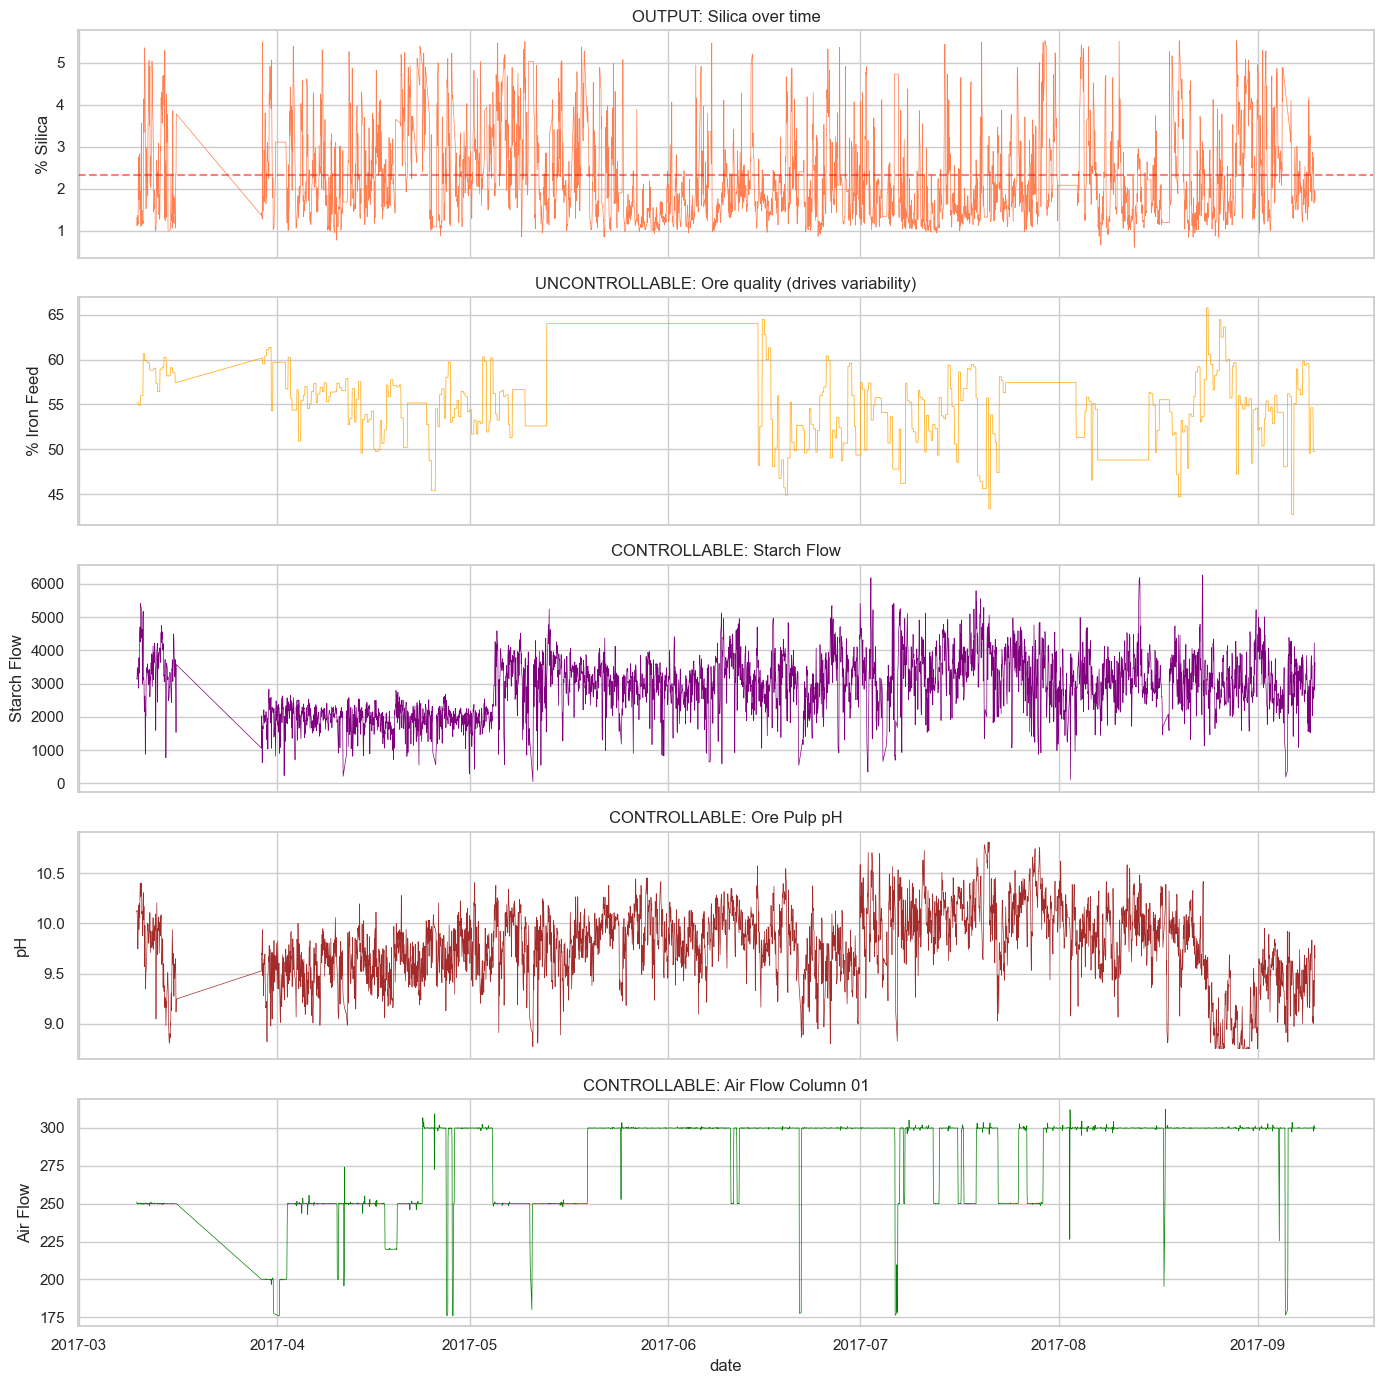

In [27]:
fig, axes = plt.subplots(5, 1, figsize=(14, 14), sharex=True)

# Output
sns.lineplot(data=df, x=df.index, y='% Silica Concentrate', ax=axes[0], linewidth=0.5, color='coral')
axes[0].axhline(df['% Silica Concentrate'].mean(), color='red', linestyle='--', alpha=0.5)
axes[0].set_ylabel('% Silica')
axes[0].set_title('OUTPUT: Silica over time')

# Ore quality
sns.lineplot(data=df, x=df.index, y='% Iron Feed', ax=axes[1], linewidth=0.5, color='orange')
axes[1].set_ylabel('% Iron Feed')
axes[1].set_title('UNCONTROLLABLE: Ore quality (drives variability)')

# Reagent
sns.lineplot(data=df, x=df.index, y='Starch Flow', ax=axes[2], linewidth=0.5, color='purple')
axes[2].set_ylabel('Starch Flow')
axes[2].set_title('CONTROLLABLE: Starch Flow')

# pH
sns.lineplot(data=df, x=df.index, y='Ore Pulp pH', ax=axes[3], linewidth=0.5, color='brown')
axes[3].set_ylabel('pH')
axes[3].set_title('CONTROLLABLE: Ore Pulp pH')

# Air Flow
sns.lineplot(data=df, x=df.index, y='Flotation Column 01 Air Flow', ax=axes[4], linewidth=0.5, color='green')
axes[4].set_ylabel('Air Flow')
axes[4].set_title('CONTROLLABLE: Air Flow Column 01')

plt.tight_layout()
plt.savefig('../data/processed/eda_08_timeseries.png', dpi=150)

### Business Insight:

- **Ore quality varies significantly** - main source of uncontrollable variability
- **Operators adjust settings in response** - see step changes in air flow, pH
- **Process is REACTIVE** - adjustments happen AFTER seeing bad quality
- Digital twin could make it **PROACTIVE** - predict before lab results arrive

## EDA Summary: Actionable Decisions

### Data Quality
| Check | Result | Action |
|-------|--------|--------|
| Missing values | None | Proceed |
| Outliers | <1.5% | Keep - most models handle them |
| Data volume | 4,097 hours | Sufficient |

### Feature Decisions
| Feature | Decision | Reason |
|---------|----------|--------|
| % Iron Concentrate | **DROP** | It's an OUTPUT, not input |
| % Silica Feed | **DROP** | Redundant with % Iron Feed (corr -0.97) |
| Starch Flow | **LOG TRANSFORM** | Heavily skewed (range 55-6270) |
| All others | **KEEP** | All carry information |

### Why We Preprocess for AutoML

AutoML libraries try **multiple model types** (trees, linear, SVM, neural nets). Different models need different prep:

| Model Type | Needs Standardization? | Handles Skewness? |
|------------|----------------------|-------------------|
| Tree-based (XGBoost, LightGBM) | No | Yes |
| Linear Regression | **Yes** | No - needs transform |
| SVM, KNN | **Yes** | No - needs transform |
| Neural Networks | **Yes** | No - needs transform |

**Rule: Prepare for the worst case.** Standardization doesn't hurt trees but is required for linear models.

### Final Feature Set: 20 inputs → 1 output

### Questions for Operations Team
1. Are Air Flow columns 01-03 physically linked (one valve)?
2. Why are columns 04-05 nearly constant?
3. What is the time lag between changing settings and seeing effect in lab?

---
## Step 9: Preprocessing for AutoML

Now we prepare the data so it works well with ANY model type AutoML might choose.

In [28]:
from sklearn.preprocessing import StandardScaler
import joblib

# Start with a copy
df_processed = df.copy()

# --- Step 9a: Drop redundant/leakage features ---
drop_cols = [
    '% Silica Feed',      # 97% correlated with % Iron Feed
    '% Iron Concentrate', # Output - not an input (leakage)
]
df_processed = df_processed.drop(columns=drop_cols)
print(f"Dropped: {drop_cols}")
print(f"Remaining columns: {len(df_processed.columns)}")

# --- Step 9b: Log-transform heavily skewed features ---
# Starch Flow has range 55-6270, heavily right-skewed
df_processed['Starch Flow'] = np.log1p(df_processed['Starch Flow'])
print(f"\nLog-transformed: Starch Flow")
print(f"  Before: range 55-6270")
print(f"  After:  range {df_processed['Starch Flow'].min():.2f}-{df_processed['Starch Flow'].max():.2f}")

Dropped: ['% Silica Feed', '% Iron Concentrate']
Remaining columns: 21

Log-transformed: Starch Flow
  Before: range 55-6270
  After:  range 4.02-8.74


In [29]:
# --- Step 9c: Standardize all numeric features ---
# We do NOT standardize the target (% Silica Concentrate)

target_col = '% Silica Concentrate'
feature_cols = [col for col in df_processed.columns if col not in [target_col, 'date']]

print(f"Features to standardize: {len(feature_cols)}")

# Fit scaler on feature columns
scaler = StandardScaler()
df_processed[feature_cols] = scaler.fit_transform(df_processed[feature_cols])

print(f"\nAfter standardization (should be mean≈0, std≈1):")
print(df_processed[feature_cols].describe().T[['mean', 'std']].head(10).round(3))

Features to standardize: 20

After standardization (should be mean≈0, std≈1):
                              mean  std
% Iron Feed                   -0.0  1.0
Starch Flow                    0.0  1.0
Amina Flow                     0.0  1.0
Ore Pulp Flow                 -0.0  1.0
Ore Pulp pH                   -0.0  1.0
Ore Pulp Density              -0.0  1.0
Flotation Column 01 Air Flow   0.0  1.0
Flotation Column 02 Air Flow  -0.0  1.0
Flotation Column 03 Air Flow  -0.0  1.0
Flotation Column 04 Air Flow   0.0  1.0


In [30]:
# --- Step 9d: Save everything ---

# Save preprocessed data
df_processed.to_csv('../data/processed/mining_automl_ready.csv', index=False)

# Save the scaler so we can transform new data or inverse-transform predictions
joblib.dump(scaler, '../data/processed/feature_scaler.joblib')

# Save feature names for reference
joblib.dump(feature_cols, '../data/processed/feature_names.joblib')

print("Saved:")
print("  - data/processed/mining_automl_ready.csv (preprocessed data)")
print("  - data/processed/feature_scaler.joblib (to transform new data)")
print("  - data/processed/feature_names.joblib (feature column names)")
print(f"\nFinal dataset shape: {df_processed.shape}")

Saved:
  - data/processed/mining_automl_ready.csv (preprocessed data)
  - data/processed/feature_scaler.joblib (to transform new data)
  - data/processed/feature_names.joblib (feature column names)

Final dataset shape: (4097, 21)


### Preprocessing Summary

| Step | What | Why |
|------|------|-----|
| Drop % Silica Feed | Remove redundant feature | 97% correlated with % Iron Feed |
| Drop % Iron Concentrate | Remove output used as input | Leakage - not available at prediction time |
| Log-transform Starch Flow | `log(1+x)` | Extreme skewness hurts linear models |
| Standardize all features | Scale to mean=0, std=1 | Required for linear/SVM/NN, harmless for trees |

**Important:** We save the scaler because:
1. New data must be transformed the same way before prediction
2. If you want to interpret coefficients, you need to inverse-transform